# Objective
* 20190707:
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Instead of using last value method, we use prophet package to predict
    * Instead of using 3 years of training, here we just use 1 year

In [127]:
%matplotlib inline

import math
import matplotlib
import multiprocessing
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import date, datetime, timedelta
from fbprophet import Prophet
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

#### Input params ##################
stk_path = "./data/VTI_20130102_20181231.csv"
H = 21                          # Forecast horizon
train_size = 252*1              # Use 1 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set
changepoint_prior_scale_list = [0.05, 0.5, 1, 1.5, 2.5]     # for hyperparameter tuning
fourier_order_list = [None, 2, 4, 6, 8, 10]                 # for hyperparameter tuning
holidays_path = "./data/holidays.csv"                       # csv file containing holidays in the US
window_list = [None, 0, 1, 2]                               # for hyperparameter tuning

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 504


# Common functions

In [128]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_preds_prophet(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Use Prophet to forecast for the next H timesteps, starting at df[len(df)]
    Inputs
        df: dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H : forecast horizon
        changepoint_prior_scale : to detect changepoints in time series analysis trajectories
        fourier_order           : determines how quickly seasonality can change
        holidays                : dataframe containing holidays you will like to model. 
                                  Must have 'holiday' and 'ds' columns
    Outputs
        A list of predictions
    """
    # Fit prophet model
    if holidays is not None:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=holidays)
    else:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
    if (fourier_order is not None) and (~np.isnan(fourier_order)): # add monthly seasonality
        m.add_seasonality(name='monthly', period=21, fourier_order=int(fourier_order))

    m.fit(df)
    
    # Make future dataframe
    future = m.make_future_dataframe(periods=2*H)
    
    # Eliminate weekend from future dataframe
    future['day'] = future['ds'].dt.weekday
    future = future[future['day']<=4]
    
    # Predict
    forecast = m.predict(future) # Note this prediction includes the original dates
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    return forecast['yhat'][len(df):len(df)+H]
    
def get_error_metrics(df, H, train_size, val_size, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    assert len(df) == train_size + val_size
    
    # Predict using Prophet, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    
    rmse_mean, mape_mean, mae_mean = get_preds_prophet_parallelized(df, H, changepoint_prior_scale, fourier_order, holidays)

    return rmse_mean, mape_mean, mae_mean, _

def hyperparam_tune_cp(df, H, train_size, val_size, changepoint_prior_scale_list):
    """
    Hyperparameter tuning - changepoint
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale_list: list of changepoint_prior_scale values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for changepoint_prior_scale in tqdm_notebook(changepoint_prior_scale_list):
        print("changepoint_prior_scale = " + str(changepoint_prior_scale))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, H, train_size, val_size, changepoint_prior_scale)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
    
    # Create results dataframe
    results = pd.DataFrame({'changepoint_prior_scale': changepoint_prior_scale_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    
    # Return hyperparam corresponding to lowest error metric
    return changepoint_prior_scale_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_fo(df, H, train_size, val_size, fourier_order_list):
    """
    Hyperparameter tuning - fourier order
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        fourier_order_list     : list of fourier_order values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for fourier_order in tqdm_notebook(fourier_order_list):
        print("fourier_order = " + str(fourier_order))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, H, train_size, val_size, 0.05, fourier_order)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'fourier_order': fourier_order_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return fourier_order_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_wd(df, H, train_size, val_size, window_list, holidays):
    """
    Hyperparameter tuning - upper and lower windows for holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        window_list            : list of upper and lower window values to try
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for window in tqdm_notebook(window_list):
        print("window = " + str(window))
        
        if window is None:
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=None)
        else:
            # Add lower_window and upper_window which extend the holiday out to 
            # [lower_window, upper_window] days around the date
            holidays['lower_window'] = -window
            holidays['upper_window'] = +window
        
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=holidays)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'window': window_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return window_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_cp_fo_wd(df, H, train_size, val_size, changepoint_prior_scale_list, 
                             fourier_order_list, window_list, holidays):
    """
    Hyperparameter tuning - changepoint, fourier_order, holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale_list: list of changepoint_prior_scale values to try
        fourier_order_list          : list of fourier_order values to try
        window_list                 : list of upper and lower window values to try
        holidays                    : dataframe containing holidays you will like to model. 
                                      Must have 'holiday' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    cp_list = []
    fo_list = []
    wd_list = []
    for changepoint_prior_scale in tqdm_notebook(changepoint_prior_scale_list):
        for fourier_order in tqdm_notebook(fourier_order_list):
            for window in tqdm_notebook(window_list):
                
                if window is None:
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays=None)
                else:
                    # Add lower_window and upper_window which extend the holiday out to 
                    # [lower_window, upper_window] days around the date
                    holidays['lower_window'] = -window
                    holidays['upper_window'] = +window
        
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays)
                rmse_mean_list.append(rmse_mean)
                mape_mean_list.append(mape_mean)
                mae_mean_list.append(mae_mean)
                cp_list.append(changepoint_prior_scale)
                fo_list.append(fourier_order)
                wd_list.append(window)
        
    # Return hyperparam corresponding to lowest error metric
    results = pd.DataFrame({'changepoint_prior_scale': cp_list, 
                            'fourier_order': fo_list,
                            'window': wd_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    temp = results[results['rmse'] == results['rmse'].min()]
    changepoint_prior_scale_opt = temp['changepoint_prior_scale'].values[0]
    fourier_order_opt = temp['fourier_order'].values[0]
    window_opt = temp['window'].values[0]
    
    return changepoint_prior_scale_opt, fourier_order_opt, window_opt, results



In [129]:
def processInput(i, df, H, changepoint_prior_scale, fourier_order, holidays):
    preds_list = get_preds_prophet(df[i-train_size:i], H, changepoint_prior_scale, fourier_order, holidays)
    
    # Compute error metrics
    rmse = get_rmse(df[i:i+H]['y'], preds_list)
    mape = get_mape(df[i:i+H]['y'], preds_list)
    mae = get_mae(df[i:i+H]['y'], preds_list)
    
    return (rmse, mape, mae)

def get_preds_prophet_parallelized(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    This is a parallelized implementation of get_preds_prophet.
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    inputs = range(train_size, len(df)-H, int(H/2))

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i, df, H, changepoint_prior_scale, fourier_order, holidays) for i in inputs)
    # results has format [(rmse1, mape1, mae1), (rmse2, mape2, mae2), ...]

    rmse = [errors[0] for errors in results]
    mape = [errors[1] for errors in results]
    mae = [errors[2] for errors in results]
    
    return np.mean(rmse), np.mean(mape), np.mean(mae)

# Load data

In [130]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

# Get size of dataframe
print("len(df) = " + str(len(df)))

df.head(10)

len(df) = 1509


,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [131]:
df['date'].min(), df['date'].max() 

(Timestamp('2013-01-02 00:00:00'), Timestamp('2018-12-28 00:00:00'))

Text(0, 0.5, 'USD')

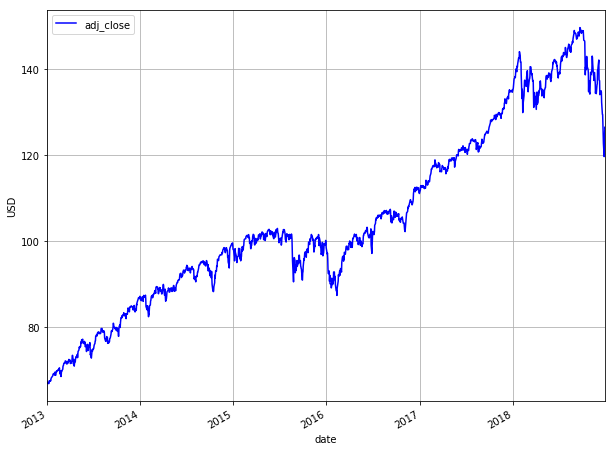

In [132]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [133]:
# Prepare dataframe for Prophet
df_prophet = df[['date', 'adj_close']].rename(columns={'date':'ds', 'adj_close':'y'})
df_prophet.head()

,ds,y
0,2013-01-02,66.997757
1,2013-01-03,66.899689
2,2013-01-04,67.238510
3,2013-01-07,67.060173
4,2013-01-08,66.881859


# Predict for a specific H (forecast horizon) and a specific date

In [134]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 504, date 2015-01-02 00:00:00, with forecast horizon H = 21


In [135]:
# Fit prophet model
m = Prophet()
m.fit(df_prophet[i-train_val_size:i])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [136]:
# Create dataframe with the dates we want to predict
future = m.make_future_dataframe(periods=2*H)

According to https://facebook.github.io/prophet/docs/non-daily_data.html, since we do not have weekend data, we should eliminate it from the future dataframe before doing predictions.

In [137]:
# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

# Predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
529,2015-02-05,98.186644,96.261107,100.028884
530,2015-02-06,98.311037,96.411272,100.027998
531,2015-02-09,98.246860,96.323302,100.068800
532,2015-02-10,98.382852,96.587927,100.183442
533,2015-02-11,98.366648,96.539914,100.215646


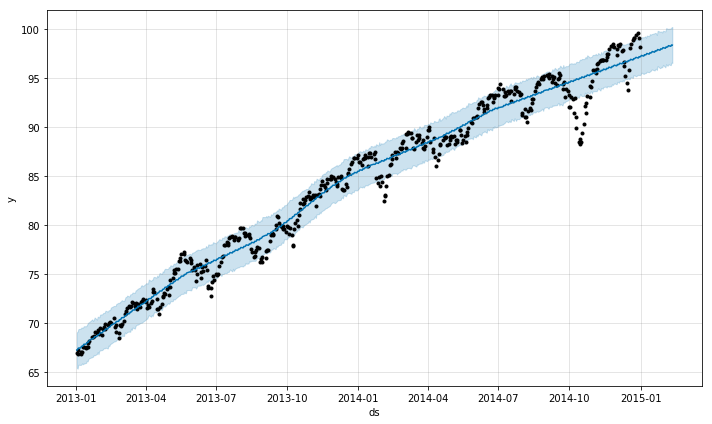

In [138]:
# Plot
m.plot(forecast);

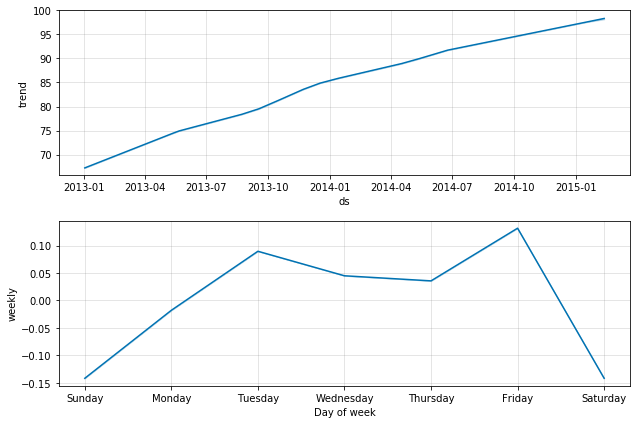

In [139]:
# Plot components
m.plot_components(forecast);

In [140]:
# Compute error metrics
preds_list = forecast['yhat'][train_val_size:train_val_size+H]
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the RMSE is 1.302096
For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the mean MAPE is 1.169449
For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the mean MAE is 1.126414


(735568.0, 735657.0)

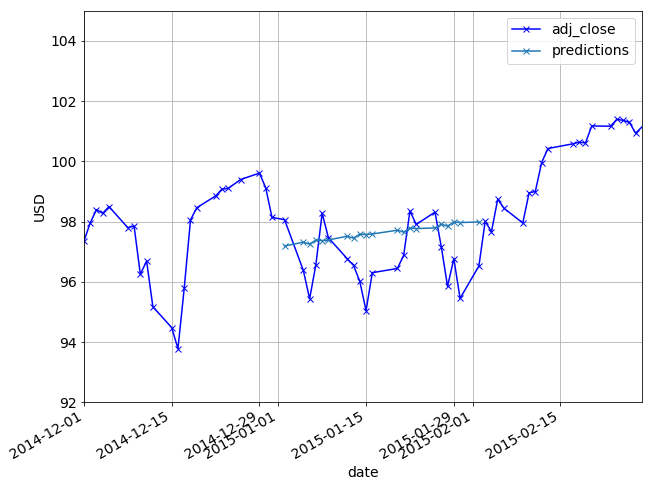

In [141]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([92, 105])
ax.set_xlim([date(2014, 12, 1), date(2015, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - changepoint

In [142]:
# Get optimum hyperparams
tic = time.time()
changepoint_opt, results = hyperparam_tune_cp(df_prophet[i-train_val_size:i], 
                                              H, 
                                              train_size, 
                                              val_size, 
                                              changepoint_prior_scale_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("changepoint_opt = " + str(changepoint_opt))

results

changepoint_prior_scale = 0.05
changepoint_prior_scale = 0.5
changepoint_prior_scale = 1
changepoint_prior_scale = 1.5
changepoint_prior_scale = 2.5

Time taken = 1.0380821347236633 mins
changepoint_opt = 0.05


,changepoint_prior_scale,rmse,mape(%),mae
0,0.05,2.329710,2.218503,2.036725
1,0.50,2.445949,2.342869,2.152950
2,1.00,2.451762,2.349042,2.158417
3,1.50,2.455246,2.352503,2.161486
4,2.50,2.456522,2.354610,2.163419


In [143]:
# Get predictions using tuned hyperparams
preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, changepoint_prior_scale=changepoint_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the RMSE is 1.302096
For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the mean MAPE is 1.169449
For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the mean MAE is 1.126414


(735568.0, 735657.0)

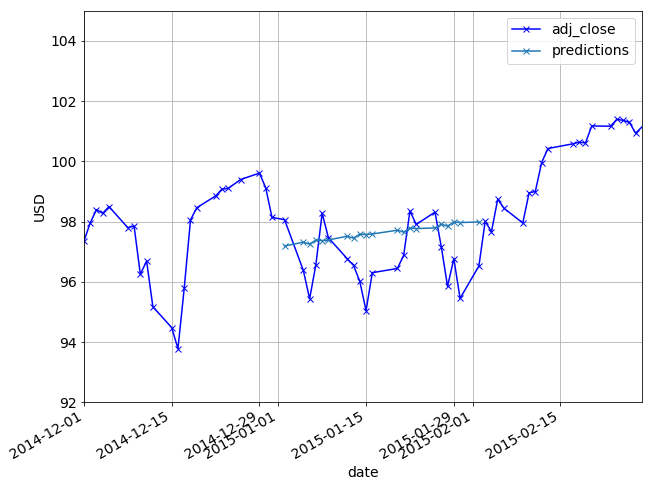

In [144]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([92, 105])
ax.set_xlim([date(2014, 12, 1), date(2015, 2, 28)])

With hyperparameter (changepoint_prior_scale) tuning, the predictions are more accurate

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - monthly seasonality

In [145]:
# Get optimum hyperparams
tic = time.time()
fourier_order_opt, results = hyperparam_tune_fo(df_prophet[i-train_val_size:i], 
                                                H, 
                                                train_size, 
                                                val_size, 
                                                fourier_order_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("fourier_order_opt = " + str(fourier_order_opt))

results

fourier_order = None
fourier_order = 2
fourier_order = 4
fourier_order = 6
fourier_order = 8
fourier_order = 10

Time taken = 1.1963772495587668 mins
fourier_order_opt = None


,fourier_order,rmse,mape(%),mae
0,NaN,2.329710,2.218503,2.036725
1,2.0,2.335274,2.223496,2.041274
2,4.0,2.338608,2.224837,2.042764
3,6.0,2.338544,2.225389,2.043217
4,8.0,2.335879,2.222997,2.041144
5,10.0,2.344752,2.233523,2.050725


In [146]:
# Get predictions using tuned hyperparams
preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, fourier_order=fourier_order_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the RMSE is 1.302096
For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the mean MAPE is 1.169449
For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the mean MAE is 1.126414


(735568.0, 735657.0)

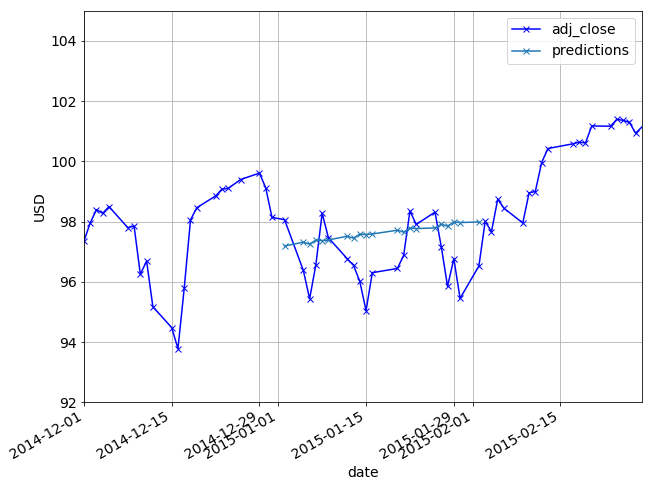

In [147]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([92, 105])
ax.set_xlim([date(2014, 12, 1), date(2015, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - holidays

In [148]:
# Load holidays file
hols = pd.read_csv(holidays_path, header=None, sep="\t", names=['ds', 'holiday'])

# Convert Date column to datetime
hols.loc[:, 'ds'] = pd.to_datetime(hols['ds'],format='%Y-%m-%d')

# Add lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date
hols['lower_window'] = 0
hols['upper_window'] = 0

hols.head()

,ds,holiday,lower_window,upper_window
0,2013-07-04,Independence Day,0,0
1,2013-09-02,Labor Day,0,0
2,2013-10-14,Columbus Day,0,0
3,2013-11-11,Veterans Day,0,0
4,2013-11-28,Thanksgiving Day,0,0


In [149]:
# Get optimum hyperparams
tic = time.time()
window_opt, results = hyperparam_tune_wd(df_prophet[i-train_val_size:i], 
                                         H, 
                                         train_size, 
                                         val_size, 
                                         window_list,
                                         hols)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("window_opt = " + str(window_opt))

results

window = None
window = 0
window = 1
window = 2

Time taken = 0.9917057832082112 mins
window_opt = 2


,window,rmse,mape(%),mae
0,NaN,2.329710,2.218503,2.036725
1,0.0,2.310367,2.200001,2.019113
2,1.0,2.304939,2.189388,2.011032
3,2.0,2.284164,2.179124,2.001354


In [150]:
# Get predictions using tuned hyperparams
if window_opt is None:
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, holidays=None)
else:
    hols['lower_window'] = -window_opt
    hols['upper_window'] = +window_opt
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, holidays=hols)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the RMSE is 1.134513
For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the mean MAPE is 1.025259
For forecast horizon 21, predicting on day 504, date 2015-01-02 00:00:00, the mean MAE is 0.989556


(735568.0, 735657.0)

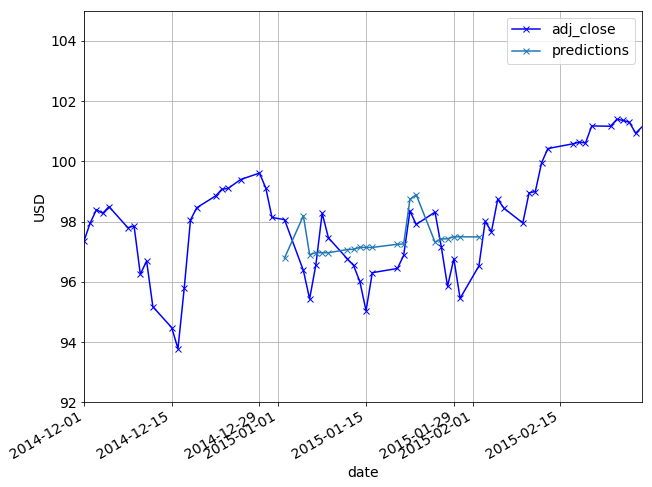

In [151]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([92, 105])
ax.set_xlim([date(2014, 12, 1), date(2015, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - changepoint, monthly seasonality, holidays

In [45]:
# Get optimum hyperparams
tic = time.time()
changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
    hyperparam_tune_cp_fo_wd(df_prophet[i-train_val_size:i], 
                             H, 
                             train_size, 
                             val_size, 
                             changepoint_prior_scale_list,
                             fourier_order_list,
                             window_list,
                             hols)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("changepoint_prior_scale_opt = " + str(changepoint_prior_scale_opt))
print("fourier_order_opt = " + str(fourier_order_opt))
print("window_opt = " + str(window_opt))
results


Time taken = 39.375811163584395 mins
changepoint_prior_scale_opt = 2.5
fourier_order_opt = nan
window_opt = 2.0


,changepoint_prior_scale,fourier_order,window,rmse,mape(%),mae
0,0.05,NaN,NaN,4.024375,3.742802,3.745053
1,0.05,NaN,0.0,4.030582,3.748668,3.751727
2,0.05,NaN,1.0,3.989878,3.706470,3.713741
3,0.05,NaN,2.0,3.918260,3.628252,3.640074
4,0.05,2.0,NaN,4.043221,3.756161,3.757569
5,0.05,2.0,0.0,4.047361,3.758449,3.760405
6,0.05,2.0,1.0,4.022516,3.732417,3.739423
7,0.05,2.0,2.0,3.959582,3.664420,3.676529
8,0.05,4.0,NaN,4.031555,3.744979,3.746405
9,0.05,4.0,0.0,4.050828,3.761835,3.764219


In [46]:
# Print the tail of the results df
results.tail()

,changepoint_prior_scale,fourier_order,window,rmse,mape(%),mae
115,2.5,8.0,2.0,3.600747,3.288928,3.300992
116,2.5,10.0,NaN,3.674620,3.378475,3.379336
117,2.5,10.0,0.0,3.684873,3.385480,3.387314
118,2.5,10.0,1.0,3.653113,3.349688,3.356336
119,2.5,10.0,2.0,3.598591,3.287265,3.299381


In [47]:
# Get predictions using tuned hyperparams
if (window_opt is None) or (np.isnan(window_opt)):
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                   H, 
                                   changepoint_prior_scale_opt, 
                                   fourier_order_opt, 
                                   holidays=None)
else:
    hols['lower_window'] = -window_opt
    hols['upper_window'] = +window_opt
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                   H, 
                                   changepoint_prior_scale_opt, 
                                   fourier_order_opt, 
                                   holidays=hols)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 2.825223
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 2.454460
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 2.772755


(736269.0, 736388.0)

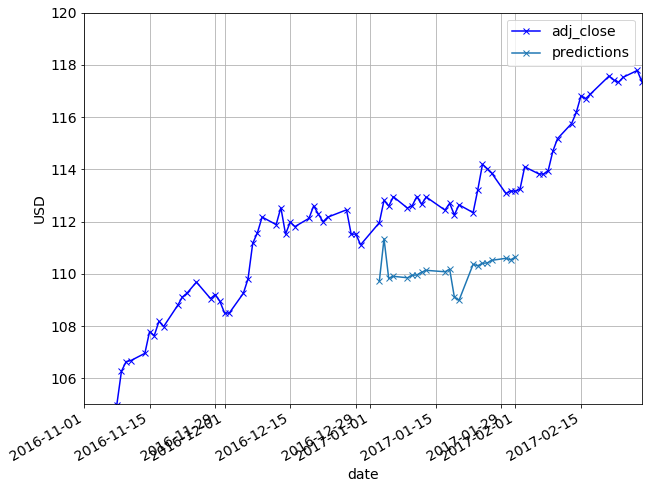

In [48]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([92, 105])
ax.set_xlim([date(2014, 12, 1), date(2015, 2, 28)])

# Predict for a specific H (forecast horizon), and various dates, using model trained in previous step

In [49]:
changepoint_prior_scale_opt = 2.5
fourier_order_opt = None
window_opt = 2.0

In [79]:
# i_list = range(1008, 1008+84*5+42+1, 42)
i_list = list(range(train_val_size, len(df_prophet)-21, 42))
i_list

[504,
 546,
 588,
 630,
 672,
 714,
 756,
 798,
 840,
 882,
 924,
 966,
 1008,
 1050,
 1092,
 1134,
 1176,
 1218,
 1260,
 1302,
 1344,
 1386,
 1428,
 1470]

In [55]:
# Predict using Prophet, and compute error metrics also
rmse = [] # root mean square error
mape = [] # mean absolute percentage error
mae = []  # mean absolute error
preds_dict = {}
H = 21 # We will test with this value of H and observe the results
for i in i_list:
# for i in tqdm_notebook(range(train_val_size, len(df)-H, int(H/2))): # Do a forecast on day i
    print("Predicting on day %d, date %s" % (i, df_prophet['ds'][i]))
    
    # Get predictions using tuned hyperparams
    if (window_opt is None) or (np.isnan(window_opt)):
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=None)
    else:
        hols['lower_window'] = -window_opt
        hols['upper_window'] = +window_opt
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=hols)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    rmse.append(get_rmse(df_prophet[i:i+H]['y'], preds_list))
    mape.append(get_mape(df_prophet[i:i+H]['y'], preds_list))
    mae.append(get_mae(df_prophet[i:i+H]['y'], preds_list))

print("Altogether we made %d forecasts, each of length %d days" % (len(rmse), H))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1008, date 2017-01-03 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1050, date 2017-03-06 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1092, date 2017-05-04 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1134, date 2017-07-05 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1176, date 2017-09-01 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1218, date 2017-11-01 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1260, date 2018-01-03 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1302, date 2018-03-06 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1344, date 2018-05-04 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1386, date 2018-07-05 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1428, date 2018-09-04 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1470, date 2018-11-01 00:00:00
Altogether we made 12 forecasts, each of length 21 days


In [56]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 2.537608
For forecast horizon 21, the mean MAPE is 1.715626
For forecast horizon 21, the mean MAE is 2.278701


In [57]:
results_final_no_tune = pd.DataFrame({'day': i_list,
                                      'changepoint_opt': [changepoint_prior_scale_opt]*len(i_list),
                                      'fourier_order_opt': [fourier_order_opt]*len(i_list),
                                      'window_opt': [window_opt]*len(i_list),
                                      'rmse': rmse,
                                      'mape': mape,
                                      'mae': mae})
results_final_no_tune

,day,changepoint_opt,fourier_order_opt,window_opt,rmse,mape,mae
0,1008,2.5,None,2.0,2.825223,2.454460,2.772755
1,1050,2.5,None,2.0,1.953373,1.364531,1.594658
2,1092,2.5,None,2.0,0.985600,0.589900,0.699982
3,1134,2.5,None,2.0,0.912894,0.661600,0.814389
4,1176,2.5,None,2.0,1.016239,0.688717,0.859945
5,1218,2.5,None,2.0,1.575529,1.007299,1.317033
6,1260,2.5,None,2.0,4.231866,2.779420,3.925767
7,1302,2.5,None,2.0,2.598751,1.453783,1.943824
8,1344,2.5,None,2.0,2.792895,1.834736,2.543126
9,1386,2.5,None,2.0,3.422192,2.302379,3.302548


Text(0, 0.5, 'USD')

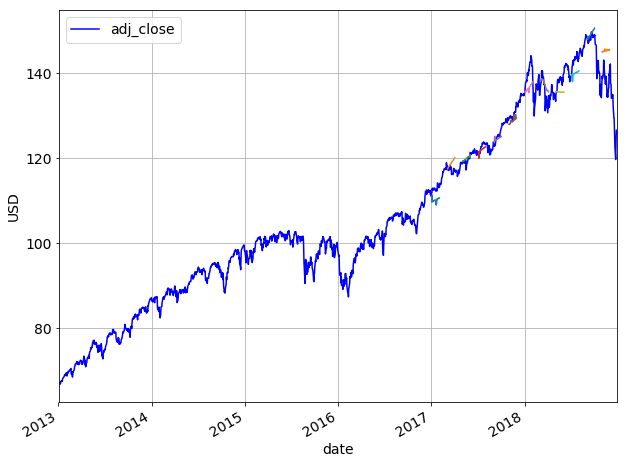

In [58]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")

(736330.0, 737059.0)

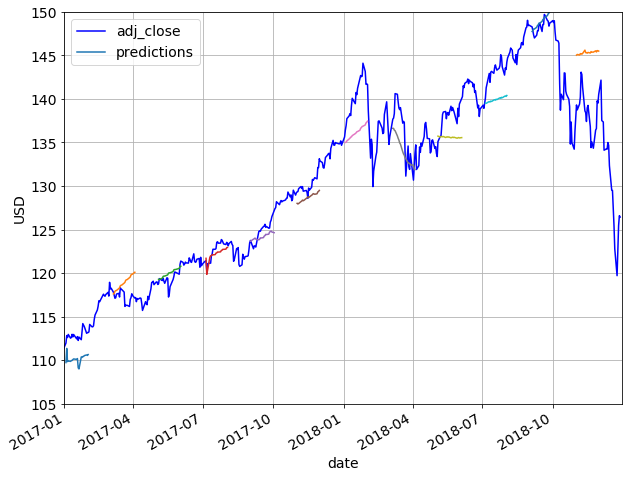

In [81]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 150])
ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

# Predict for a specific H (forecast horizon), and various dates, tuning model for every prediction

In [82]:
len(i_list)

24

In [83]:
for i in i_list:
    print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

    # Predict using Prophet, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}

    tic = time.time()
    
    changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
        hyperparam_tune_cp_fo_wd(df_prophet[i-train_val_size:i], 
                                 H, 
                                 train_size, 
                                 val_size, 
                                 changepoint_prior_scale_list,
                                 fourier_order_list,
                                 window_list,
                                 hols)
    
    # Get predictions using tuned hyperparams
    if (window_opt is None) or (np.isnan(window_opt)):
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=None)
    else:
        hols['lower_window'] = -window_opt
        hols['upper_window'] = +window_opt
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=hols)
    
    # Compute error metrics
    rmse = get_rmse(df_prophet[i:i+H]['y'], preds_list)
    mape = get_mape(df_prophet[i:i+H]['y'], preds_list)
    mae = get_mae(df_prophet[i:i+H]['y'], preds_list)

    # Put results into pickle
    pickle.dump(preds_list, open("./data/preds_list_" + str(i) + "_v2a.pickle", "wb"))
    pickle.dump(rmse, open("./data/rmse_" + str(i) + "_v2a.pickle", "wb"))
    pickle.dump(mape, open("./data/mape_" + str(i) + "_v2a.pickle", "wb"))
    pickle.dump(mae, open("./data/mae_" + str(i) + "_v2a.pickle", "wb"))
    pickle.dump(changepoint_prior_scale_opt, open("./data/changepoint_prior_scale_opt_" + str(i) + "_v2a.pickle", "wb"))
    pickle.dump(fourier_order_opt, open("./data/fourier_order_opt_" + str(i) + "_v2a.pickle", "wb"))
    pickle.dump(window_opt, open("./data/window_opt_" + str(i) + "_v2a.pickle", "wb"))
    pickle.dump(results, open("./data/results_" + str(i) + "_v2a.pickle", "wb"))
    
    toc = time.time()
    print("Time taken = " + str((toc-tic)/60.0))

Predicting on day 504, date 2015-01-02 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.43601483503978
Predicting on day 546, date 2015-03-05 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 33.84929680029551
Predicting on day 588, date 2015-05-05 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.27017468214035
Predicting on day 630, date 2015-07-06 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.355321848392485
Predicting on day 672, date 2015-09-02 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.506310880184174
Predicting on day 714, date 2015-11-02 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.278917054335274
Predicting on day 756, date 2016-01-04 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.555244251092276
Predicting on day 798, date 2016-03-04 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.48239708741506
Predicting on day 840, date 2016-05-04 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.42620843251546
Predicting on day 882, date 2016-07-05 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.11222685178121
Predicting on day 924, date 2016-09-01 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 34.05657590230306
Predicting on day 966, date 2016-11-01 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 35.40563648541768


In [84]:
# Load pickle file
# i_list = range(train_val_size, train_val_size+84*5+42+1, 42)
# i_list = [train_val_size, train_val_size+42, train_val_size+84, train_val_size+126, train_val_size+84*2, 
#           train_val_size+210, train_val_size+84*3, train_val_size+84*4, train_val_size+84*5]
preds_dict = {}
rmse, mape, mae, changepoint_prior_scale_opt, fourier_order_opt, window_opt = [], [], [], [], [], []

for i in i_list:
    preds_dict[i] = pickle.load(open( "./data/preds_list_" + str(i) + "_v2a.pickle", "rb"))
    rmse.append(pickle.load(open( "./data/rmse_" + str(i) + "_v2a.pickle", "rb")))
    mape.append(pickle.load(open( "./data/mape_" + str(i) + "_v2a.pickle", "rb")))
    mae.append(pickle.load(open( "./data/mae_" + str(i) + "_v2a.pickle", "rb")))
    changepoint_prior_scale_opt.append(pickle.load(open( "./data/changepoint_prior_scale_opt_" + str(i) + "_v2a.pickle", "rb")))
    fourier_order_opt.append(pickle.load(open( "./data/fourier_order_opt_" + str(i) + "_v2a.pickle", "rb")))
    window_opt.append(pickle.load(open( "./data/window_opt_" + str(i) + "_v2a.pickle", "rb")))

In [85]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 3.173992
For forecast horizon 21, the mean MAPE is 2.636050
For forecast horizon 21, the mean MAE is 2.908145


In [86]:
results_final = pd.DataFrame({'day': i_list,
                              'changepoint_opt': changepoint_prior_scale_opt,
                              'fourier_order_opt': fourier_order_opt,
                              'window_opt': window_opt,
                              'rmse': rmse,
                              'mape': mape,
                              'mae': mae})
results_final

,day,changepoint_opt,fourier_order_opt,window_opt,rmse,mape,mae
0,504,0.05,NaN,2.0,1.134513,1.025259,0.989556
1,546,0.05,NaN,2.0,1.223274,1.047742,1.042570
2,588,0.05,2.0,2.0,1.051172,0.801609,0.813724
3,630,0.05,NaN,2.0,2.019565,1.736970,1.749196
4,672,0.05,NaN,2.0,5.233605,5.357015,5.025234
5,714,0.05,NaN,NaN,5.919001,5.777359,5.810256
6,756,2.50,4.0,NaN,7.976601,8.361571,7.639772
7,798,2.50,NaN,NaN,7.479357,7.389278,7.258631
8,840,2.50,NaN,NaN,1.894869,1.599475,1.614447
9,882,2.50,NaN,NaN,0.952159,0.707160,0.735490


(735599.0, 737059.0)

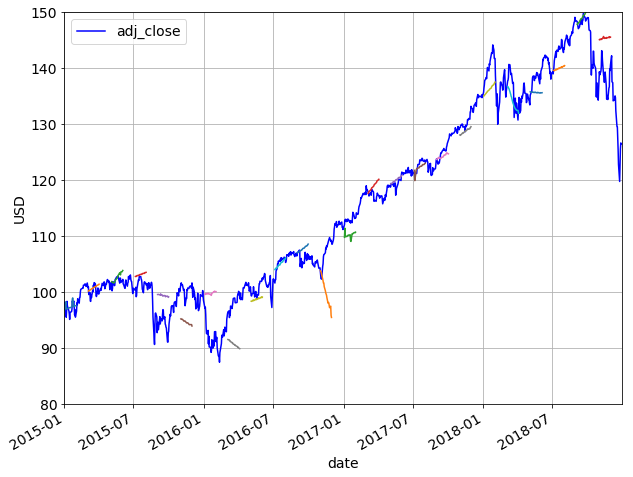

In [90]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_ylim([80, 150])
ax.set_xlim([date(2015, 1, 1), date(2018, 12, 31)])